<a href="https://colab.research.google.com/github/r1sha13h/DA5401-Kaggle-Challenge/blob/main/Kaggle_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [9]:
import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Environment Setup

Checks if a GPU (CUDA) is available and sets the device accordingly;

In [2]:
USE_CUDA = torch.cuda.is_available()
COMPUTE_DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(f"Device: {COMPUTE_DEVICE}")

DATA_FOLDER = ""
PATH_TRAIN = os.path.join(DATA_FOLDER, "train_data.json")
PATH_TEST = os.path.join(DATA_FOLDER, "test_data.json")

Device: cuda


# Load Dataset & Transform into Embeddings

Read JSON datasets (train/test) and combine the various text fields (for rich context) and generate vector embeddings using sentence transformer.

In [3]:
DIM_EMBED = 1024
MODEL_NAME = "intfloat/multilingual-e5-large"

# creates a single input string by concatenating system, user, and response prompts.
def prepare_text(row):
    sys = str(row.get("system_prompt", "")) if row.get("system_prompt") else ""
    user = str(row.get("user_prompt", ""))
    resp = str(row.get("response", ""))
    return f"{sys} [SYS] {user} [USR] {resp} [RES]"

# Load train/test data & compute embeddings for metrics (145) and text data (system, user & response prompts)
# Store embeddings to disk for later use to avoid recomputations
def embed_all():
    print("Loading data...")
    train_data = pd.DataFrame(json.load(open(PATH_TRAIN, encoding="utf8")))
    test_data = pd.DataFrame(json.load(open(PATH_TEST, encoding="utf8")))

    train_data["packed_text"] = train_data.apply(prepare_text, axis=1)
    test_data["packed_text"] = test_data.apply(prepare_text, axis=1)

    all_metrics = pd.concat([train_data["metric_name"], test_data["metric_name"]])
    metric_list = all_metrics.drop_duplicates().astype(str).to_list()

    embedder = SentenceTransformer(MODEL_NAME)
    metric_vecs = embedder.encode(metric_list, batch_size=32, convert_to_numpy=True, show_progress_bar=True)
    metric_lookup = dict(zip(metric_list, metric_vecs))

    train_met = np.stack([metric_lookup[n] for n in train_data["metric_name"].astype(str)])
    test_met = np.stack([metric_lookup[n] for n in test_data["metric_name"].astype(str)])

    train_emb = embedder.encode(train_data["packed_text"].tolist(), batch_size=16, convert_to_numpy=True, show_progress_bar=True)
    test_emb = embedder.encode(test_data["packed_text"].tolist(), batch_size=16, convert_to_numpy=True, show_progress_bar=True)

    np.save("tr_metric.npy", train_met)
    np.save("te_metric.npy", test_met)
    np.save("tr_emb.npy", train_emb)
    np.save("te_emb.npy", test_emb)
    train_y = train_data["score"].values.astype(np.float32)
    return train_met, train_emb, train_y, test_met, test_emb

if os.path.exists("/kaggle/input/multilingual-e5-large/tr_emb.npy"):
    print("Load embeddings from file...")
    train_met = np.load("/kaggle/input/multilingual-e5-large/tr_metric.npy")
    test_met = np.load("/kaggle/input/multilingual-e5-large/te_metric.npy")
    train_emb = np.load("/kaggle/input/multilingual-e5-large/tr_emb.npy")
    test_emb = np.load("/kaggle/input/multilingual-e5-large/te_emb.npy")
    train_y = pd.DataFrame(json.load(open(PATH_TRAIN, encoding="utf8")))["score"].values.astype(np.float32)
else:
    train_met, train_emb, train_y, test_met, test_emb = embed_all()

Loading data...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/228 [00:00<?, ?it/s]

Text and metric embeddings are the main input representations for the model. Using transformer-generated vectors allows semantic relationships to be captured more robustly than simple encodings.

## Visualizing Score Distribution
visualize the distribution of score labels in original training data

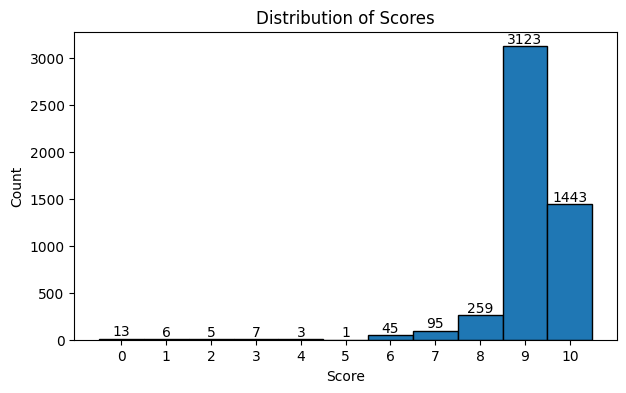

In [11]:
plt.figure(figsize=(7,4))
counts, bins, patches = plt.hist(train_y, bins=np.arange(-0.5, 11.5, 1), edgecolor='black')
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Scores')
plt.xticks(np.arange(0, 11, 1))

# Annotate counts over each bar
for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width()/2, count, int(count),
             ha='center', va='bottom', fontsize=10, color='black')

plt.show()

# Dataset Augmentation

Apply several methods for augmenting the dataset using synthetic training samples to make the model training robust:

* Method-1: Pairs each metric vector with a randomly chosen text embedding, simulating mismatches.
* Method-2: Add Gaussian noise to text embeddings to simulate corrupted or outlier data.
* Method-3: Swap metric embeddings among samples to break correct pairing.

Each pairing is given a random low score (the target), and then all data are concatenated.

In [4]:
print("Augment data...")
RNG = np.random.default_rng(seed=69)
ntrain = train_met.shape[0]

idx_shuffle1 = RNG.permutation(ntrain)
neg1_met = train_met
neg1_emb = train_emb[idx_shuffle1]
neg1_y = RNG.integers(0, 4, size=ntrain).astype(np.float32)

neg2_met = train_met
neg2_emb = train_emb + RNG.normal(0, 0.6, size=train_emb.shape).astype(np.float32)
neg2_y = RNG.integers(0, 4, size=ntrain).astype(np.float32)

idx_shuffle2 = RNG.permutation(ntrain)
neg3_met = train_met[idx_shuffle2]
neg3_emb = train_emb
neg3_y = RNG.integers(0, 4, size=ntrain).astype(np.float32)

emb_all = np.vstack([train_emb, neg1_emb, neg2_emb, neg3_emb])
met_all = np.vstack([train_met, neg1_met, neg2_met, neg3_met])
y_all = np.concatenate([train_y, neg1_y, neg2_y, neg3_y], axis=0)
print("Aug shape:", emb_all.shape[0])

Augment data...
Aug shape: 20000


Data augmentation forces the model to learn discriminative patterns rather than memorizing direct text-response matches. It simulates noisy and adversarial scenarios, improving generalization.

## Visualizing Score Distribution
visualize the distribution of score labels for synthetic and training data combined

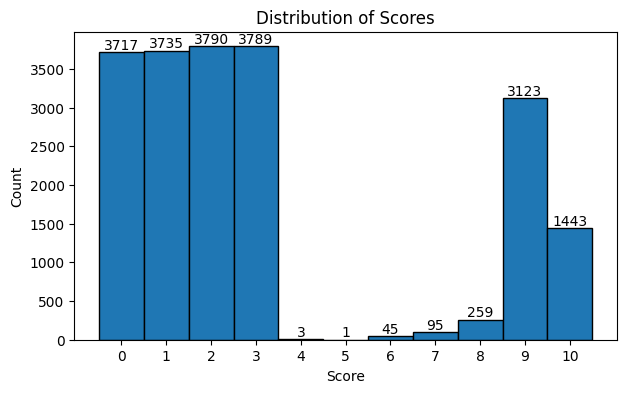

In [12]:
plt.figure(figsize=(7,4))
counts, bins, patches = plt.hist(y_all, bins=np.arange(-0.5, 11.5, 1), edgecolor='black')
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Scores')
plt.xticks(np.arange(0, 11, 1))

# Annotate counts over each bar
for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width()/2, count, int(count),
             ha='center', va='bottom', fontsize=10, color='black')

plt.show()

# Feature Engineering

Build feature array for every sample, containing:

*	Metric vector
* Text vector
* Absolute difference
* Elementwise product
* Cosine similarity (between normalized metric/text vectors)

Final feature size: 4097, capturing detailed relationships.

In [5]:
def join_features(vmet, vtxt):
    x1 = np.abs(vmet - vtxt)
    x2 = vmet * vtxt
    vmet_norm = vmet / (np.linalg.norm(vmet, axis=1, keepdims=True) + 1e-8)
    vtxt_norm = vtxt / (np.linalg.norm(vtxt, axis=1, keepdims=True) + 1e-8)
    x3 = (vmet_norm * vtxt_norm).sum(axis=1, keepdims=True)
    feat = np.hstack([vmet, vtxt, x1, x2, x3])
    return feat.astype(np.float32)

print("Form training feature array...")
X_train = join_features(met_all, emb_all)
print("Form test feature array...")
X_test = join_features(test_met, test_emb)
print("Feature columns:", X_train.shape[1])

Form training feature array...
Form test feature array...
Feature columns: 4097


Combining multiple types of similarity and interaction features helps the model learn complex relationships, not just raw vector values.

# The ML model

	Define a MLP (multi-layer perceptron) with layers and dropout for deep regression.

In [6]:
class WideMLP(nn.Module):
    def __init__(self, in_dim):
        super(WideMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.layers(x).squeeze(-1)

class FeatData(Dataset):
    def __init__(self, arr_x, arr_y):
        self.x = arr_x
        self.y = arr_y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

This deep neural net can learn highly non-linear mappings from feature vectors to scores, capturing intricate structure in the data.

# Training & K Fold Validation

* Set up a K-fold cross-validation to train and validate the model across splits.
* Tracks best validation RMSE and saves the best model snapshot.
* At end of each fold, generates out-of-fold validation predictions and test predictions for ensembling.


Running Fold 1/5
Best RMSE Fold 1: 2.4273


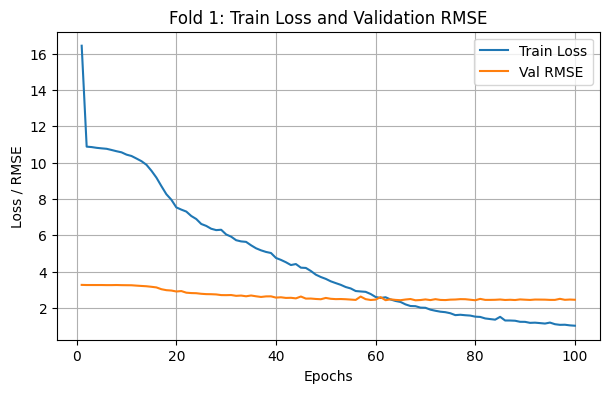


Running Fold 2/5
Best RMSE Fold 2: 2.3999


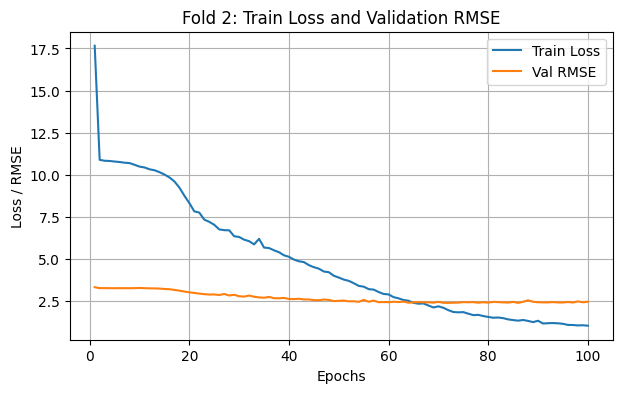


Running Fold 3/5
Best RMSE Fold 3: 2.4302


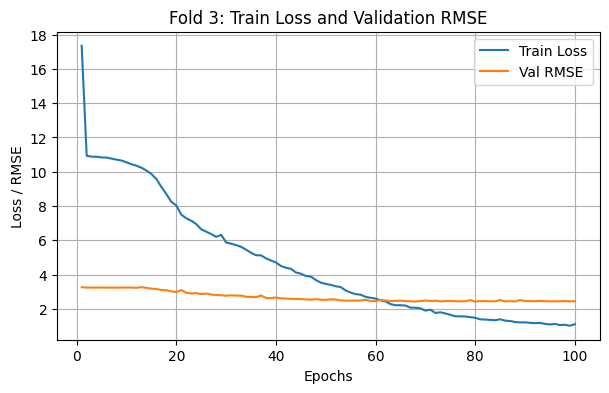


Running Fold 4/5
Best RMSE Fold 4: 2.4689


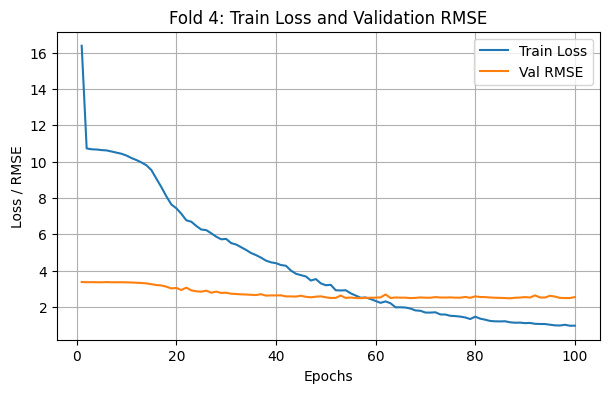


Running Fold 5/5
Best RMSE Fold 5: 2.3748


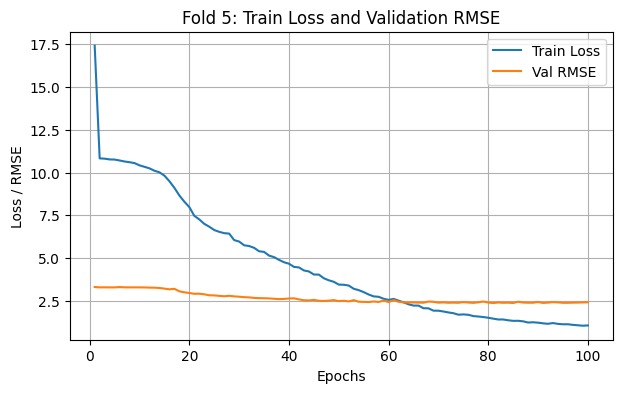

In [14]:
K_FOLDS = 5
TOTAL_EPOCHS = 100
batch_size = 256
learning_rate = 0.0001

crossval = KFold(n_splits=K_FOLDS, shuffle=True, random_state=69)
oof_result = np.zeros(len(X_train))
eval_test = np.zeros((K_FOLDS, len(X_test)))

for k, (trid, vid) in enumerate(crossval.split(X_train)):
    print(f"\nRunning Fold {k+1}/{K_FOLDS}")
    X_tr, y_tr = X_train[trid], y_all[trid]
    X_val, y_val = X_train[vid], y_all[vid]

    trainset = FeatData(X_tr, y_tr)
    valset = FeatData(X_val, y_val)

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

    net = WideMLP(X_train.shape[1]).to(COMPUTE_DEVICE)
    optimr = optim.AdamW(net.parameters(), lr=learning_rate)
    mseloss = nn.MSELoss()

    lowest_val_rmse = np.inf

    # For plotting
    epoch_train_losses = []
    epoch_val_rmses = []

    for epoch in range(TOTAL_EPOCHS):
        net.train()
        total_loss = 0.0
        for bx, by in trainloader:
            bx, by = bx.to(COMPUTE_DEVICE), by.to(COMPUTE_DEVICE)
            optimr.zero_grad()
            bpredict = net(bx)
            lossval = mseloss(bpredict, by)
            lossval.backward()
            optimr.step()
            total_loss += lossval.item() * bx.shape[0]

        epoch_train_losses.append(total_loss/len(X_tr))

        net.eval()
        val_predictions = []
        val_targets = []
        with torch.no_grad():
            for bx, by in valloader:
                bx = bx.to(COMPUTE_DEVICE)
                val_predictions.append(net(bx).cpu().numpy())
                val_targets.append(by.numpy())
        vals_pred = np.concatenate(val_predictions)
        vals_true = np.concatenate(val_targets)
        curr_rmse = np.sqrt(mean_squared_error(vals_true, vals_pred))
        epoch_val_rmses.append(curr_rmse)
        if curr_rmse < lowest_val_rmse:
            lowest_val_rmse = curr_rmse
            torch.save(net.state_dict(), f"statement-model-{k+1}.pth")
    print(f"Best RMSE Fold {k+1}: {lowest_val_rmse:.4f}")

    # ----------- Fold Plotting -----------
    epochs = np.arange(1, TOTAL_EPOCHS + 1)
    plt.figure(figsize=(7,4))
    plt.plot(epochs, epoch_train_losses, label='Train Loss')
    plt.plot(epochs, epoch_val_rmses, label='Val RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('Loss / RMSE')
    plt.title(f'Fold {k+1}: Train Loss and Validation RMSE')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------- End Plot -----------
    net.load_state_dict(torch.load(f"statement-model-{k+1}.pth"))
    net.eval()
    with torch.no_grad():
        oof_chunk = []
        for bx, _ in valloader:
            bx = bx.to(COMPUTE_DEVICE)
            oof_chunk.append(net(bx).cpu().numpy())
        oof_result[vid] = np.concatenate(oof_chunk)
        ts_preds_fold = []
        ts_loader = DataLoader(torch.tensor(X_test), batch_size=batch_size, shuffle=False)
        for bx in ts_loader:
            bx = bx.to(COMPUTE_DEVICE)
            ts_preds_fold.append(net(bx).cpu().numpy())
        eval_test[k] = np.concatenate(ts_preds_fold)

Cross-validation ensures robust performance estimation, prevents overfitting, and helps generalize the model across unseen data. Saving test fold predictions across splits allows for robust ensembling.

# Calibration & post processing the output

* Train a simple linear regression on out-of-fold predictions and true targets to rescale (“calibrate”) model predictions.
* Apply calibration to averaged test predictions from all folds.
* Clip outputs to a valid range () as required by the problem statement.
* Map each prediction to the second-nearest integer value for scoring.

In [17]:
print("Calibrating outputs...")
out_regr = LinearRegression()
out_regr.fit(oof_result.reshape(-1, 1), y_all)
print("Calibration slope:", out_regr.coef_[0], "Intercept:", out_regr.intercept_)

test_avg_pred = eval_test.mean(axis=0)
finalres_pred = out_regr.predict(test_avg_pred.reshape(-1, 1))
finalres_pred = np.clip(finalres_pred, 0, 10)
finalres_pred = np.round(finalres_pred).astype(int)

output_ids = np.arange(1, len(finalres_pred) + 1)
submission_data = pd.DataFrame({"ID": output_ids, "score": finalres_pred})
submission_data.to_csv("result.csv", index=False)
print("Results saved to 'result.csv'")

Calibrating outputs...
Calibration slope: 0.860513922519523 Intercept: 0.5172953028264744
Results saved to 'result.csv'


Calibration aligns model outputs to actual target distributions, compensates for bias, and improves submission accuracy. Second-nearest rounding gives predicted score that have a lower RMSE